## Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Setting up the Size of the Matplotlib Figures
plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
import seaborn as sns

## Dataset

In [3]:
# Load the Dataset into the Memory
deals = pd.read_csv('../GTQ+PYR Deals/Data/deal-details-infomation.csv')

In [4]:
deals.head()

,Deal_ID,Title,Category,Event,Location,Budget,Gathering,Event_Date,Deal_Date,Artists_Pitched,Artists_Requested,Artists_Requested_URL,status,lost_reason,Source
0,2481,Gautam,1,18.0,"Lonavala, Maharashtra, India",50000.0,100.0,09-04-2018,23-03-2018 07:50,"(https://starclinch.com/diljit-dosanjh, https:...",NaN,NaN,lost,Booked Another Artist Elsewhere,32.0
1,11439,Navjot deal,12,24.0,"Dehradun, Uttarakhand, India",3000.0,25.0,23-11-2017,13-11-2017 04:45,"https://starclinch.com/ishaan-dobhal-official,...",Panahe,https://www.starclinch.com/panahe,lost,Old CRM,31.0
2,11484,Souvik deal,12,18.0,"Kolkata, West Bengal, India",500000.0,1500.0,24-11-2017,10-11-2017 18:39,https://starclinch.com/rahul-jain,Rahul Jain,https://www.starclinch.com/rahul-jain,lost,Old CRM,31.0
3,11440,Harshal Dongre deal,3,15.0,"Mumbai, Maharashtra, India",60000.0,2000.0,22-12-2017,12-11-2017 20:51,"https://starclinch.com/aakash-gupta, https://s...",Kunal Kamra,https://www.starclinch.com/kunal-kamra,lost,Old CRM,31.0
4,9596,Ashok Agarwal deal,12,17.0,NaN,100000.0,500.0,15-04-2018,02-02-2018 08:14,https://starclinch.com/youthellennium-dance-ac...,Preety Bhalla,https://www.starclinch.com/preety-bhalla,lost,Old CRM,31.0


In [5]:
# Event is from 15-28 but should be in range (1-14)
deals['Event'] = deals['Event'].apply(lambda x: x - 14)

In [6]:
# Converting Date Columne to Pandas DataTime
deals['Event_Date'] = pd.to_datetime(deals['Event_Date'], errors = 'coerce')
deals['Deal_Date'] = pd.to_datetime(deals['Deal_Date'], errors = 'coerce')

In [7]:
# Artists Information
artists_df = pd.read_csv('../GTQ+PYR Deals/Data/ArtistsMapping.csv')

Converting Categories from String Value to Integer i.e giving each Category a `unique INT` Value.

In [8]:
category_2_idx = {
    "anchor/emcee": 1,
    "celebrity appearance": 2,
    "comedian": 3,
    "dancer/troupe": 4,
    "dj": 5,
    "instrumentalist": 6,
    "live band": 7,
    "magician": 8,
    "make-up artist/stylist": 9,
    "model": 10,
    "photo/videographer": 11,
    "singer": 12,
    "speaker": 13,
    "variety artists": 14
}

artists_df['CategoryName'] = artists_df['CategoryName'].str.lower().map(category_2_idx)

In [9]:
artists_df.head()

,UserId,CategoryName,ProfileUrl
0,159366,7.0,adam-and-the-fish-eyed-poets
1,136731,7.0,ashes-in-flames
2,158520,7.0,fovea
3,136307,7.0,frozen-chimes
4,232701,7.0,-killchain-india


## Processing Deals Details

In [10]:
def parseURL(x):
    if isinstance(x, str):
        x = x.replace("?id_op=0b8edebf-3814-4f91-9d3e-e4de26129e2b", "")
        x = x.replace("?id_op=6eafd9ee-d4aa-45e2-ac04-5fa15540860d", "")
        x = x.replace("?id_op=80d1fab3-d9d3-4463-9309-08189a42f28c", "")
        x = x.replace("?id_op=1bYuH", "")
        x = x.replace("?id_op=b8ccbbfc-ba89-4551-bc28-e2b2710ab52b", "")
        x = x.replace("?id_op=dad6cb11-8dc2-4f7f-a379-84c58df4d3a1", "")
        
        x = x.replace("(", "").replace(",", "\n").replace("\r", "")
        return x.split("\n")

def getArtists(X):
    if isinstance(X, list):
        artists = [url.split("/")[-1] for url in X]
        artists = set(artists)
        
        return artists
    
def allArtists(x):
    if isinstance(x, set):
        return ", ".join(x)

In [11]:
deals['Artists_Pitched'] = deals['Artists_Pitched'].apply(parseURL)
deals['Artists_Requested_URL'] = deals['Artists_Requested_URL'].apply(parseURL)

In [12]:
deals['Artists_Pitched'] = deals['Artists_Pitched'].apply(getArtists)
deals['Artists_Requested_URL'] = deals['Artists_Requested_URL'].apply(getArtists)

In [13]:
deals['Artists_Pitched'] = deals['Artists_Pitched'].apply(allArtists)
deals['Artists_Requested_URL'] = deals['Artists_Requested_URL'].apply(allArtists)

In [14]:
deals.loc[deals['Artists_Pitched'] == "", 'Artists_Pitched'] = None

### 1. Removing multiple values from Category and replacing it with single value

In [15]:
# Fill the NaN in Category with -1
deals['Category'].fillna(-1, inplace = True)

In [16]:
# Convert the Category to String
deals['Category'] = deals['Category'].astype('str')

# Split the multiple values in Category Column
## Select the first value as the value for Category corresponding to that deal
deals['Category'] = deals['Category'].apply(lambda x: x.split(",")[0])

# Convert back the Category Column to INT
deals['Category'] =  deals['Category'].astype('int64')

In [17]:
def soup(x):
    x_1 = x['Artists_Pitched']
    x_2 = x['Artists_Requested_URL']
    
    if x_1 is None:
        return x_2
    if x_2 is None:
        return x_1
    return "{0}, {1}".format(x_1, x_2)

deals['Artists'] = deals.apply(soup, axis = 1)

In [18]:
deals['Artists'] = deals['Artists'].apply(lambda x: "".join(x.split(r",")[0]) if x != None else None)

### 2. Merging DF with Artists DataFrame to get the missing Categories Values.

Merge the `deals` dataframe with `artists_df` dataframe on `ProfileUrl` to get missing value for categories

In [19]:
# Left Merge
deals = deals.merge(artists_df[['CategoryName', 'ProfileUrl']], 
                    left_on = ['Artists'], right_on = ['ProfileUrl'], 
                    how = 'left')

In [20]:
# Fill the Category Column using CategoryName value
deals.loc[deals['Category'] == -1, 'Category'] = deals['CategoryName']

In [21]:
# Drop Duplicat
deals.drop_duplicates(subset = ['Deal_ID'], inplace = True)

In [22]:
# Drop the Extra Columns
deals.drop(['CategoryName', 'ProfileUrl', 'Artists'], axis = 1, inplace = True)

In [23]:
# Save the DataFrame to the CSV Format
deals.to_csv('../GTQ+PYR Deals/Data/updated-deal-details-infomation.csv')

## EDA

#### <b>Question 1. Checking
    1.0 Total Number of Deals
    1.1 Number of `Unknown Deals`
    1.2 Number of Deals with Budget as `0`
    1.3 Number of Deals with `Date` Missing
    1.4 Number of Deals with `Location` Missing
    1.5 Number of Deals with `Category` Missing
    1.6 Number of Deals in which Artist was Pitched.

In [24]:
#1.0
print (f"Total Number of Deals: {deals.shape[0]}\n")
# 1.1
print (f"Number of Unknown Deals: {deals[(deals['Title'].str.contains('Unknown'))].shape[0]}")
# 1.2
print (f"Number of Deals with 0 Budget: {deals[(deals['Budget'] == 0)].shape[0]}")
# 1.3
print (f"Number of Deals with Date Missing: {deals[deals['Event_Date'].isnull() == True].shape[0]}")
# 1.4
print (f"Number of Deals with Location Missing: {deals[deals['Location'].isnull() == True].shape[0]}")
#1.5
print (f"Number of Deals with Category Missing: {deals[deals['Category'].isnull() == True].shape[0]}\n")
#1.6
print (f"Number of Deals with Artists Pitched: {deals[deals['Artists_Pitched'].isnull() != True].shape[0]}")

Total Number of Deals: 14894

Number of Unknown Deals: 92
Number of Deals with 0 Budget: 247
Number of Deals with Date Missing: 160
Number of Deals with Location Missing: 1096
Number of Deals with Category Missing: 476

Number of Deals with Artists Pitched: 1359


#### Artists Pitched

In [25]:
artist_pitched = deals.Artists_Pitched.str.split(r',', expand=True).stack().unique().shape[0]
total_artists = artists_df.shape[0]

In [26]:
print (f"Number of Artists Pitched {artist_pitched} out of {total_artists} Total Artists.")
print (f"Percentage of Artists Pitched: {(artist_pitched / total_artists) * 100} %")

Number of Artists Pitched 2652 out of 11679 Total Artists.
Percentage of Artists Pitched: 22.707423580786028 %


#### <b>Question 2.</b>
Total Number of `Deals` available with all the necessary information i.e `Deal_ID`, `Category`, `Event` `Type`, `Budget`, `Gathering`, `Date` and `Location`.

In [27]:
# Deals with all the Information
deals[['Deal_ID', 'Title', 'Category', 'Event', 'Location', 'Budget', 'Event_Date']].dropna().shape[0]

13345

#### <b>Question 3: </b> 
Which `Category` have Maximum Number of Deal ?

Category List

    1: Anchor/EMCEE
    2: Celebrity Appearance
    3: Comedian
    4: Dance/Troupe
    5: DJ
    6: Instrumentalist
    7: Live Band
    8: Magician
    9: Makeup Artist
    10: Model
    11: Photo/Videographer
    12: Singer
    13: Speaker
    14: Variety Artists

In [28]:
top_categories = deals.groupby('Category')['Category'].size()
top_categories

Category
1.0      946
2.0     1666
3.0     3206
4.0      455
5.0      896
6.0      290
7.0     1744
8.0      129
9.0      105
10.0     429
11.0      99
12.0    4189
13.0      93
14.0     171
Name: Category, dtype: int64

Text(0.5,1,'Deal Distribution based on Categories')

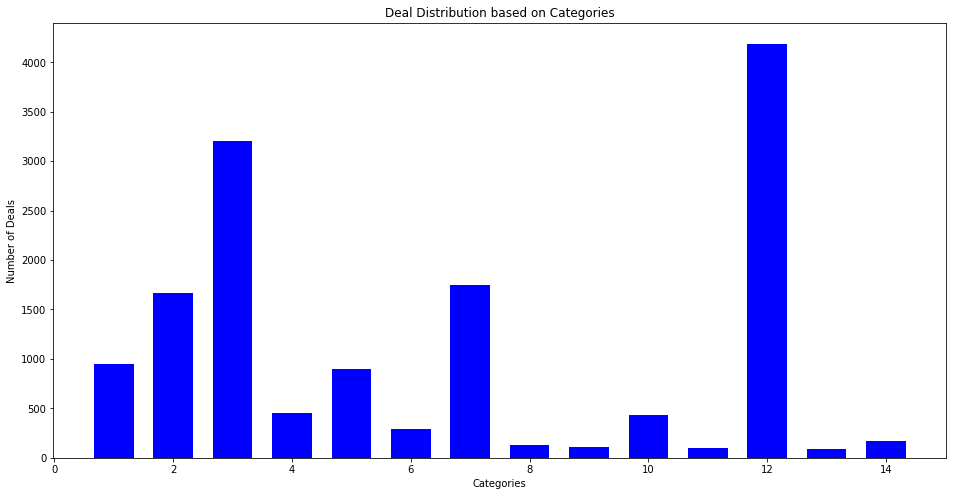

In [29]:
plt.bar(range(1, 15), top_categories.values, width = 1/1.5, color = "blue")
plt.xlabel('Categories')
plt.ylabel('Number of Deals')

plt.title("Deal Distribution based on Categories")

`Singer` (Category 12) is at the top followed by `Comedian` (Category 3) and `Live Band` (Category 7)

#### <b>Question 4: </b> 
Which Event have Maximum Number of Deal ?

Event List:

    1: Campus
    2: Charity
    3: Concert/Festival
    4: Corporate
    5: Exhibition
    6: Fashion Show
    7: Inauguration
    8: Kids Party
    9: Photo/Video Shoot
    10: Private Party
    11: Professional Hiring
    12: Religious
    13: Restaurant
    14: Wedding

In [30]:
top_events = deals.groupby('Event')['Event'].size()
top_events

Event
1.0     3015
2.0      564
3.0     1908
4.0     1963
5.0      114
6.0      205
7.0      514
8.0      277
9.0      395
10.0    1905
11.0     276
12.0     336
13.0     384
14.0    2753
Name: Event, dtype: int64

Text(0.5,1,'Deal Distribution based on Events')

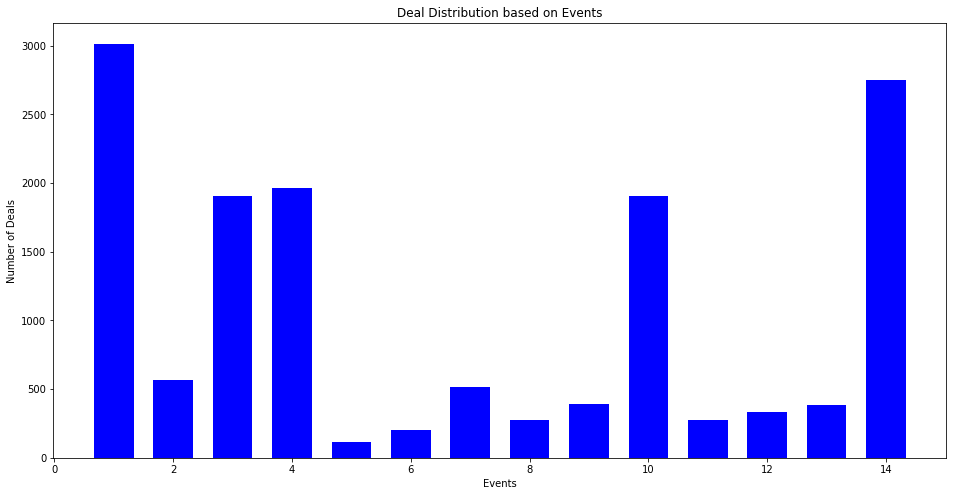

In [31]:
plt.bar(range(1, 15), top_events.values, width = 1/1.5, color = "blue")
plt.xlabel('Events')
plt.ylabel('Number of Deals')

plt.title("Deal Distribution based on Events")

`Campus Events` are more in demand followed by `Weddings` and `Corporate Events`.

Text(0.5,1,'Event Distribution over the Years')

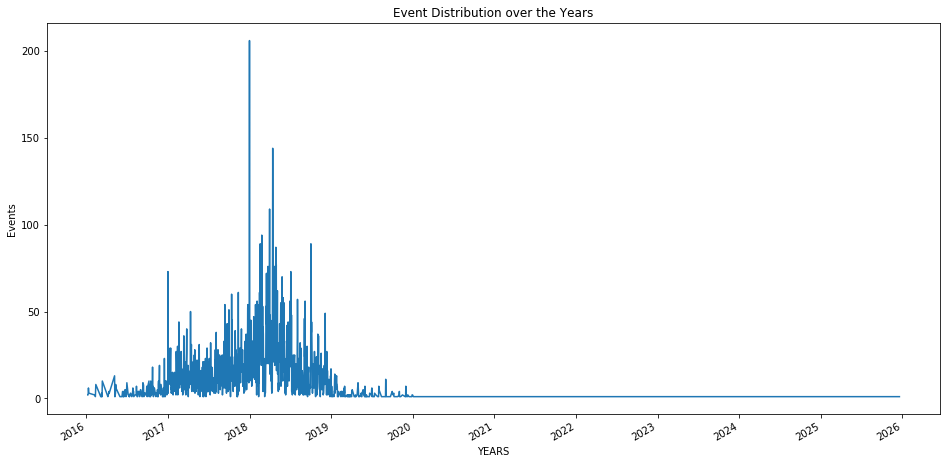

In [32]:
grouped = deals.groupby(['Event_Date'])['Event_Date'].size()

grouped.plot()

plt.xlabel('YEARS')
plt.ylabel('Events')
plt.title('Event Distribution over the Years')

Text(0.5,1,'Deals Distribution over the Years')

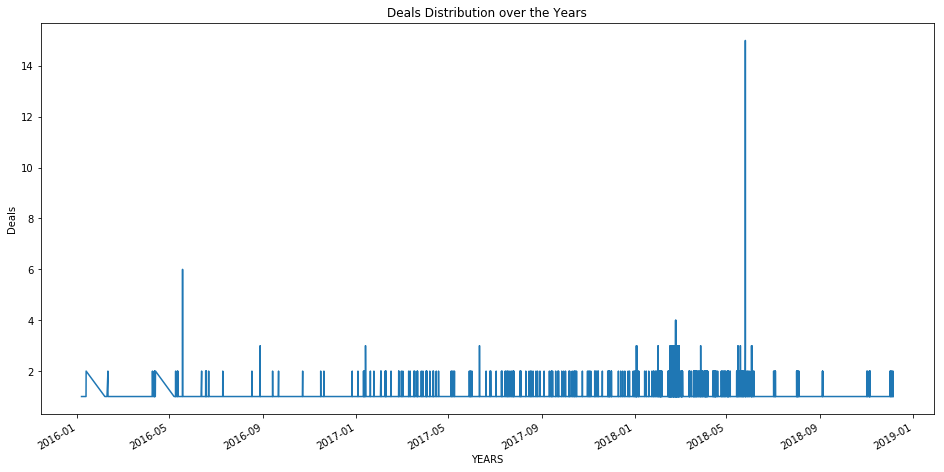

In [33]:
grouped = deals.groupby(['Deal_Date'])['Deal_Date'].size()

grouped.plot()

plt.xlabel('YEARS')
plt.ylabel('Deals')
plt.title('Deals Distribution over the Years')

## K-Means Clustering

In [34]:
UserInfo = pd.read_csv('../GTQ+PYR Deals/Data/PYR.csv')

In [35]:
# Select the Columns to get Clusters around
columns = ['Category', 'Event', 'Budget', 'Gathering', 'Event_Month']
X = UserInfo[columns].values

# Normalize the Values
X = stats.zscore(X)

### Number of Clusters
`GET` the number of Clusters using the Elbow Technique. 

In [38]:
Nc = range(1, 40)

kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

Text(0.5,1,'Elbow Curve')

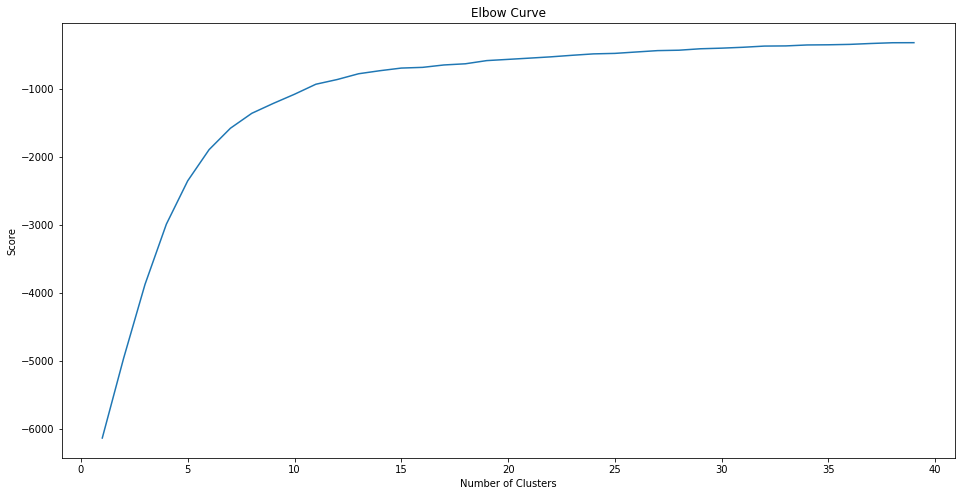

In [39]:
plt.plot(Nc,score)

plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

### Clustering Data

In [40]:
# Initialize KMeans Clustering Algorithm with Number of Clusters as 3
kmeans = KMeans(n_clusters = 10, random_state = 0)

# Fit the Normalized Data
kmeans = kmeans.fit(X)

In [41]:
# Add Cluster to the Original Dataset
UserInfo['clusters'] = kmeans.labels_

In [42]:
# Add the clusters column to the list
columns.extend(['clusters'])

In [43]:
# Lets analyze the clusters
print (UserInfo[columns].groupby(['clusters']).mean())

           Category      Event        Budget      Gathering  Event_Month
clusters                                                                
0         11.956522  16.434783  3.299710e+05    4120.724638     9.884058
1         11.780488  26.073171  2.765416e+05     505.682927     3.178862
2          4.500000  25.950000  1.353250e+05     380.708333    10.450000
3          7.000000  22.750000  1.625000e+07    1087.500000     5.500000
4          7.000000  17.000000  2.000000e+06  600000.000000     2.000000
5          3.318367  16.865306  1.632653e+05    1736.869388     9.620408
6          3.601351  16.668919  2.173819e+05    2056.807432     3.195946
7         11.943396  16.047170  6.199151e+05    5590.433962     2.924528
8         11.932692  26.711538  2.991154e+05     515.019231     9.701923
9          4.406250  25.975000  1.138750e+05     550.337500     4.025000


In [45]:
def plot(X, y, data):
    return sns.lmplot(X, y, 
                      data = data, 
                      hue = 'clusters', 
                      fit_reg = False, 
                      scatter_kws={"marker": "D", "s": 100}
                     )

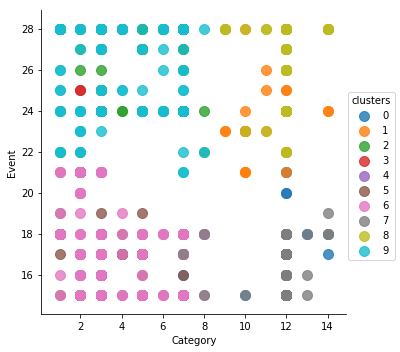

In [46]:
plot('Category', 'Event', UserInfo)

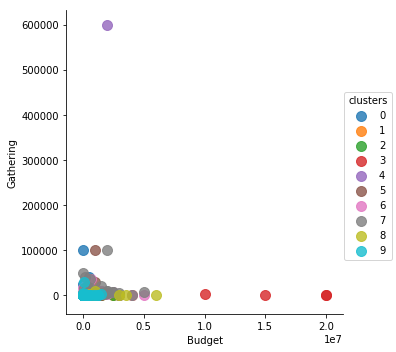

In [47]:
plot('Budget', 'Gathering', UserInfo)

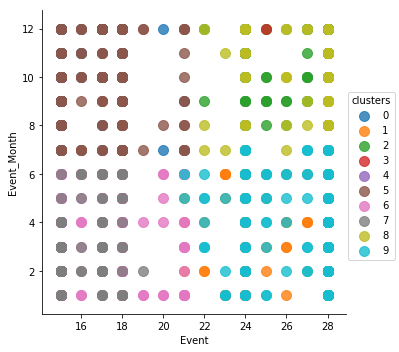

In [48]:
plot('Event', 'Event_Month', UserInfo)

## Artists Pitch Count

In [49]:
# Split the Artists into multiple Columns
x = deals.Artists_Pitched.str.split(r',', expand=True).stack().reset_index(level=1, drop=True).to_frame('Artists_Pitched')
x = pd.get_dummies(x, columns=['Artists_Pitched']).groupby(level=0).sum()

In [50]:
# Load Pitch Count DataFrame
pitch_count = pd.read_csv('../GTQ+PYR Deals/Data/PitchCount.csv')

In [51]:
# Count How many times a artists has been pitched to the User
'''
def getCount(col):
    return x[x[col] == 1][col].shape[0]

counts = []
for i in x.columns.values:
    c = getCount(i)
    gC = (i.replace('Artists_Pitched_', "").strip(), c)
    
    counts.append(gC)
'''

'\ndef getCount(col):\n    return x[x[col] == 1][col].shape[0]\n\ncounts = []\nfor i in x.columns.values:\n    c = getCount(i)\n    gC = (i.replace(\'Artists_Pitched_\', "").strip(), c)\n    \n    counts.append(gC)\n'

In [52]:
# Artists Pitch Count DataFrame
# pitch_count = pd.DataFrame(counts, columns = ['Artist', 'Pitch Count'])
# Save the DataFrame to the CSV Format.
# pitch_count.to_csv('../GTQ+PYR Deals/Data/PitchCount.csv', index = False)

In [53]:
# GET the Artists with the Maximum Pitch Count
pitch_count.sort_values(by = ['Pitch Count'], ascending = False).head()

,Artist,Pitch Count
1093,manish-tyagi,95
990,kishore-dayani,79
1793,sumit-anand,76
894,jeeveshu-ahluwalia,60
304,appurv-gupta,57


## END